In [1]:
import os
os.chdir("..")

import numpy as np
import torch
from src.randomizedSignature import rSig, rSigKer
from src.neuralSigKers import NeuralSigKer, inhomNeuralSigKer
from src.utils import augment_with_time, ReLU_phi
from matplotlib import pyplot as plt
from tqdm import tqdm

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Utils

In [2]:
def generate_BM(batch, timesteps, d, T=1.0):
    
    times = torch.linspace(0., T, timesteps)
    dt = times[1]
    
    dB = np.sqrt(dt)*torch.normal(0,1.0,size = (batch, timesteps-1, d)).to(device)
    dB = torch.cat((torch.zeros((batch, 1, d)).to(device).float(), dB), dim=1)
    
    # B: (batch, timesteps, d)
    B = dB.cumsum(dim=1) 
    
    return B

def generate_paths(batch, timesteps):
    
    times = torch.linspace(0., 1, timesteps)
    
    x = torch.stack([np.sin(w*times).double() for w in np.linspace(5,8,batch) ])
    x = x[..., None]

    y = torch.stack([np.cos(w*times).double() + 3*np.exp(times).double() for w in np.linspace(13,16,batch)])
    y = y[..., None]
    
    return torch.cat([x, y], dim=-1)

In [3]:
from scipy.stats import multivariate_normal

def plot_pdf_comparison(ax, results, std_ReLU, std_id, sample_mean, sample_std, N):
    
    n, bins, patches = ax.hist(results.detach().numpy(), bins=50, density=True, alpha=0.6, color='Skyblue')
    
    # Plot the PDF.
    xmin, xmax = bins[0], bins[-1]
    grid = np.linspace(xmin, xmax, 100)
    
    p = norm.pdf(grid, 0, std_ReLU)
    p2 = norm.pdf(grid, sample_mean, sample_std)
    p3 = norm.pdf(grid, 0, std_id)

    ax.plot(grid, p2, '-', linewidth=2, label = 'Nearest Gaussian fit', color = 'orange')
    ax.plot(grid, p, 'k--', linewidth=2, label='Theoretical density - ReLU')
    ax.plot(grid, p3, '-', linewidth=2, label='Theoretical density - Id', color = 'red')
    
    ax.set_title("Hidden Dimension = {}".format(N))
    ax.legend()
    
    
def plt_cov_comparison(ax_1, ax_2, results, Sigma_ReLU, Sigma_id, N):
    
    ax_1.scatter(results[:, 0], results[:, 1], s=3, c='Skyblue')
    ax_2.scatter(results[:, 0], results[:, 1], s=3, c='Skyblue')

    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    
    grid_x = np.linspace(xmin, xmax, 100)
    grid_y = np.linspace(ymin, ymax, 100)

    grid_x, grid_y = np.meshgrid(grid_x, grid_y)
    pos  = np.dstack((grid_x, grid_y))
    rv_ReLU   = multivariate_normal([0, 0], Sigma_ReLU)
    rv_id   = multivariate_normal([0, 0], Sigma_id)
    Z_ReLU = rv_ReLU.pdf(pos)
    Z_id = rv_id.pdf(pos)

    ax_1.contour(grid_x, grid_y, Z_ReLU)
    ax_2.contour(grid_x, grid_y, Z_id)
    
    ax_1.set_title("Theoretical density - ReLU | Hidden Dimension = {}".format(N))
    ax_2.set_title("Theoretical density - Id | Hidden Dimension = {}".format(N))
    

# Randomized Signatures

## Generate Datasets

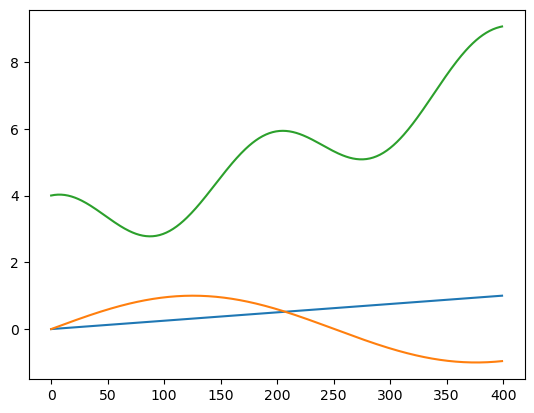

In [4]:
# Hyperparameters
batch, timesteps, d = 4, 400, 2
ReLU = lambda x : x * (x > 0)

# Data
# I: (timesteps, )
I = torch.linspace(0, 1.0, timesteps)
# X: (batch, timesteps, 1+d)
X = augment_with_time(generate_BM(batch, timesteps, d))
# Y: (batch, timesteps, 1+2)
Y = augment_with_time(generate_paths(batch, timesteps))

#plt.plot(X[0, :,1], X[0, :,2])
plt.plot(Y[0])

## rSig 

In [5]:
data = Y
N = 100

d_augmented = data.shape[-1]
sigmas = {"sigma_0": 1.0, "sigma_A": .4, "sigma_b": 0.3}

model = rSig(input_channels=d_augmented,
             hidden_channels=N,
             activation=ReLU,
             sigmas=sigmas,
             cubic=False)

tensor(True)


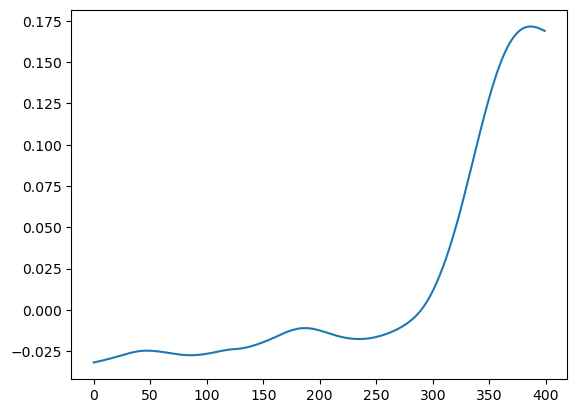

In [6]:
# Compute only last value.
# S_0: (batch, N)
S_0 = model.forward(data)/np.sqrt(N) 

# Compute whole path.
# S_1: (batch, timesteps, N)
S_1 = model.forward(data, interval = I, interval_return=I)/np.sqrt(N) # (batch, timesteps, N)

print((S_1[:, -1, :] ==  S_0).all())
plt.plot(S_1[1, :, 0])

## rSigKer

In [9]:
Kernel = rSigKer(hidden_dim=30,
                 MC_iters=10,
                 activation=ReLU,
                 sigmas=sigmas)

In [10]:
G = Kernel.compute_Gram_matrix(X, X, interval_return=I, sym=True)
print(G.shape)

M = Kernel.MMD(X, X)
print(M.shape)

D = Kernel.RKHS_dist(X, X, sym=True)
print(D.shape)

100%|██████████| 10/10 [00:38<00:00,  3.83s/it]


torch.Size([4, 4, 400, 400])


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


torch.Size([])


100%|██████████| 10/10 [00:37<00:00,  3.71s/it]

torch.Size([4, 4])


# Neural SigKer

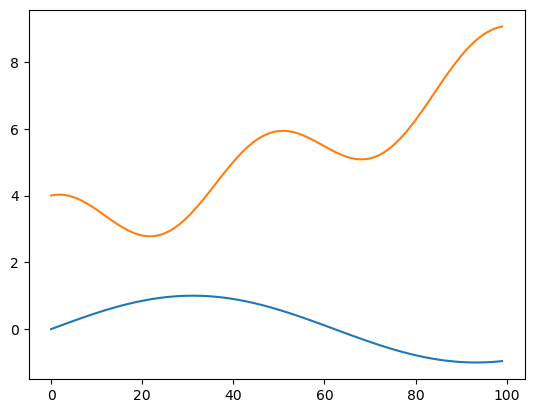

In [4]:
# Hyperparameters
batch, timesteps = 80, 100
ReLU = lambda x : x * (x > 0)

# data: (batch, timesteps, 2)
data = generate_paths(batch, timesteps)
X = data[..., 0].unsqueeze(-1)
Y = data[..., 1].unsqueeze(-1)

#plt.plot(X[0, :,1], X[0, :,2])
plt.plot(data[0])

In [7]:
sigmas={"sigma_0": 1.0, "sigma_A": 1.0, "sigma_b": 2.0}
neural_Kernel = NeuralSigKer(sigmas=sigmas)

G = neural_Kernel.compute_Gram(X, Y, sym=False, max_batch=50)
print('G: ', G.shape)

K = neural_Kernel.kernel(X, Y)
print('K: ', K.shape)

G:  torch.Size([80, 80, 100, 100])
K:  torch.Size([80, 100, 100])


In [8]:
sigmas={"sigma_0": 1.0, "sigma_A": 1.0, "sigma_b": 2.0}
inhom_neural_Kernel = inhomNeuralSigKer(sigmas=sigmas)

G = inhom_neural_Kernel.compute_Gram(X, X, sym=True, max_batch=50)
print('G: ', G.shape)

K = inhom_neural_Kernel.kernel(X, Y)
print('K: ', K.shape)

G:  torch.Size([80, 80, 100])
K:  torch.Size([80, 100])


# Convergence

Fix Hyperparameters and datasets

In [7]:
# Hyperparameters
batch, timesteps = 1, 1000
ReLU = lambda x : x * (x > 0)
sigmas={"sigma_0": 1.0, "sigma_A": 2.5, "sigma_b": 2.0}

# data: (batch, timesteps, 2)
times = torch.linspace(0, 1, timesteps)
X = np.sin(7*times).unsqueeze(-1).unsqueeze(0)
Y = (np.cos(15*times) + 3*np.exp(times)).unsqueeze(-1).unsqueeze(0)


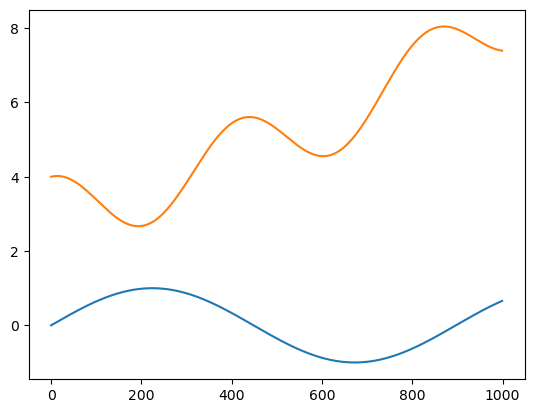

In [8]:
plt.plot(X[0])
plt.plot(Y[0])

Generate first M samples of rSigs

In [ ]:
d, hidden_dims, M = 1, [50, 100, 150, 200], 700

results = torch.zeros((len(hidden_dims), M, 2)).to(device)
for k in range(len(hidden_dims)):
    N = hidden_dims[k]
    for iter in tqdm(range(M)):

        # Random initializations
        model = rSig(input_channels=d,
                     hidden_channels=N,
                     activation=ReLU,
                     sigmas=sigmas,
                     cubic=False)

        v = torch.normal(0.0, 1.0/np.sqrt(N), size = (N, 1)).to(device)

        # Compute rSig on data
        # S_xy: (batch_x + batch_y, N)
        S_xy = model.forward(torch.cat((X, Y), dim=0))

        # Compute dot product
        # S_xy@v: (batch_x + batch_y, 1)
        results[k, iter, :] = (S_xy@v)[:, 0]

means = results.mean(dim = 1)
stds = results.std(dim=1) #(results - results.mean(dim=0)).std(dim=0)
cov = (results[:,:,0]*results[:,:,1]).mean(dim=1)

print('')
print('means =  {}'.format(means))
print('stds =  {}'.format(stds))
print('cov =  {}'.format(cov))

Compute the Kernels

In [17]:
# ReLU Kernel

ReLU_K = NeuralSigKer(ReLU_phi, sigmas=sigmas)

ReLU_Kxx = ReLU_K._kernel_same(X)
ReLU_Kyy = ReLU_K._kernel_same(Y)
ReLU_Kxy = ReLU_K.compute_Gram(X, Y, ReLU_Kxx, ReLU_Kyy)

ReLU_stds = [np.sqrt(ReLU_Kxx[0, -1,-1].detach().numpy()), np.sqrt(ReLU_Kyy[0, -1,-1].detach().numpy())]
ReLU_Sigma = torch.Tensor([[ReLU_Kxx[0, -1, -1], ReLU_Kxy[0, 0, -1, -1]],[ReLU_Kxy[0, 0, -1, -1], ReLU_Kyy[0, -1, -1]]])

# id Kernel

id_K = NeuralSigKer(sigmas=sigmas)

id_Kxx = id_K._kernel_same(X)
id_Kyy = id_K._kernel_same(Y)
id_Kxy = id_K.compute_Gram(X, Y, id_Kxx, id_Kyy)

id_stds = [np.sqrt(id_Kxx[0, -1,-1].detach().numpy()), np.sqrt(id_Kyy[0, -1,-1].detach().numpy())]
id_Sigma = torch.Tensor([[id_Kxx[0, -1, -1], id_Kxy[0, 0, -1, -1]],[id_Kxy[0, 0, -1, -1], id_Kyy[0, -1, -1]]])

Compare!

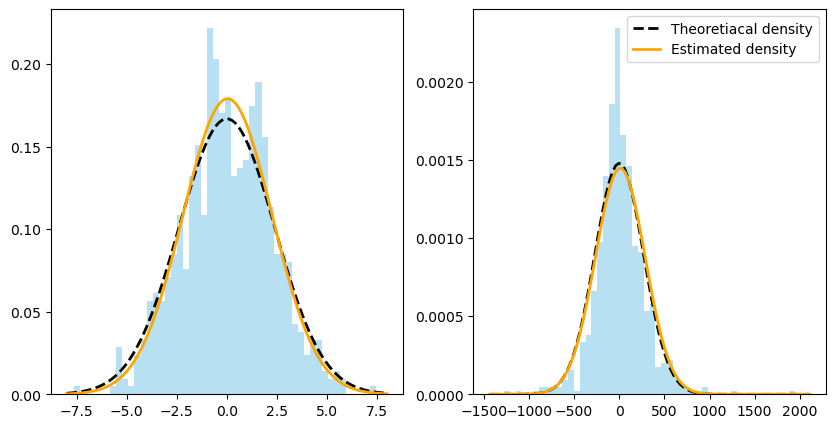

Teoretical stds: [2.390048, 269.60406]
Estimated stds: tensor([[  2.2716, 490.6619],
        [  2.3293, 272.9949],
        [  2.3202, 282.7951],
        [  2.2267, 275.3580]])


In [25]:
from scipy.stats import norm

# Plots
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot results for x
## Plot the histogram.
ax[0].hist(results[-1,:,0].detach().numpy(), bins=50, density=True, alpha=0.6, color='Skyblue')
## Plot the PDF.
xmin, xmax = -8, 8
grid = np.linspace(xmin, xmax, 100)
p = norm.pdf(grid, 0, ReLU_stds[0])
p2 = norm.pdf(grid, means[-1,0], stds[-1,0])

ax[0].plot(grid, p, 'k--', linewidth=2)
ax[0].plot(grid, p2, '-', linewidth=2, color = 'orange')


# Plot results y
## Plot the histogram.
ax[1].hist(results[-1,:,1].detach().numpy(), bins=50, density=True, alpha=0.6, color='Skyblue')
## Plot the PDF.
xmin, xmax = plt.xlim()
grid = np.linspace(xmin, xmax, 100)
p = norm.pdf(grid, 0, ReLU_stds[1])
p2 = norm.pdf(grid, means[-1,1], stds[-1,1])

ax[1].plot(grid, p, 'k--', linewidth=2, label='Theoretiacal density')
ax[1].plot(grid, p2, '-', linewidth=2, label = 'Estimated density', color = 'orange')


plt.legend()
plt.show()

print('Teoretical stds: {}'.format([ReLU_stds[0], ReLU_stds[1]]))
print('Estimated stds: {}'.format(stds))

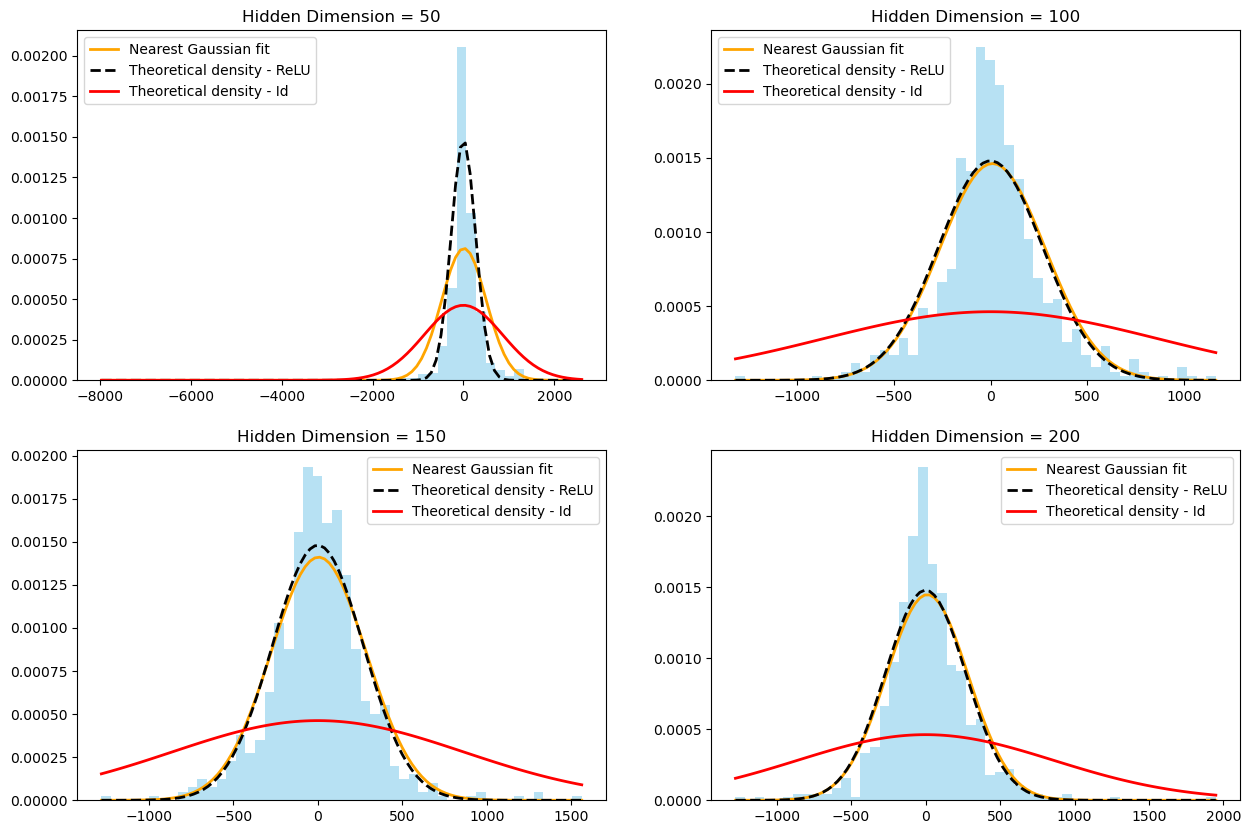

In [26]:
i = 1

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for k in range(4):
    plot_pdf_comparison(ax[int(k/2),k%2], results[k,:,i], ReLU_stds[i], id_stds[i], means[k,i], stds[k,i], hidden_dims[k])


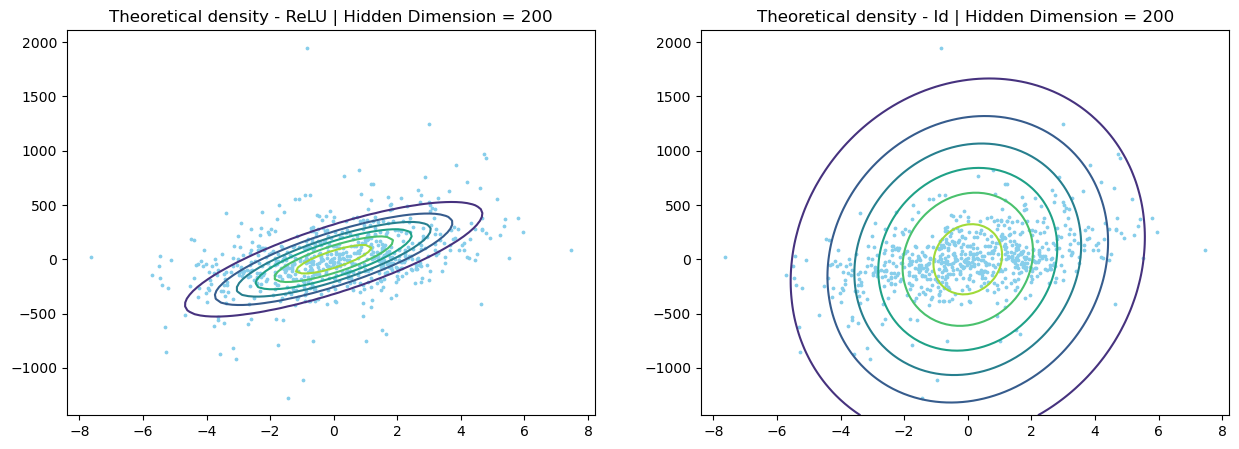

In [27]:
i = 1
k = -1

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt_cov_comparison(ax[0], ax[1], results[k], ReLU_Sigma, id_Sigma, hidden_dims[k])